# Replicate the article - Genetic Algortihm

#### Step 1. Feature Ranking (Filter Method):
    
    - ReliefF: Apply the ReliefF attribute evaluator with the Ranker search method to rank features based on their relevance to the target variable.
    
    - FCBF: Apply the FCBF attribute evaluator with the Ranker search method to rank features based on their consistency and redundancy.
    
    - Selection Criteria: Choose a threshold (30%) to select the top-ranked features from both ReliefF and FCBF results. Combine these selected features using the intersection (∩) operation.

#### Step 2. GA-Based Feature Selection (Wrapper Method):

    - (1) Genotype Representation: Encode each feature as a binary gene (1 for selected, 0 for not selected). A chromosome represents a potential feature subset.
    - (2) Population Initialization: Create an initial population of chromosomes (e.g., 50 chromosomes).
    - (3) Fitness Function: Use the classification accuracy of a chosen classifier (e.g., SVM, NB, DTree, etc.) on the feature subset represented by the chromosome to evaluate its fitness.
    - (4) Genetic Operators:
        - Selection: Rank-based selection (select chromosomes with better fitness scores).
        - Crossover: Use one-point crossover to combine genetic material from two parent chromosomes.
        - Mutation: Apply a single-point mutation to flip a bit (0 to 1 or 1 to 0) in a chromosome.
    - (5)Iteration: Repeat steps of evaluating fitness (3) and applying genetic operators (4) for a specified number of generations.
    - (6) Stopping Criteria: Stop the GA when the best fitness score remains constant for a specific number of generations.
    - (7) Feature Subset: The chromosome with the highest fitness score after the GA process represents the optimal feature subset.

#### Step 3. Ensemble Learning:
    
    - Basic Learners: Train different classifiers (e.g., SVM, NB, DTree, MLP, KNN, RFC, LR) on the selected feature subset obtained from the GA.
    - Meta-Learner: Use the AdaBoost algorithm as the meta-learner. The meta-learner combines the predictions from the basic learners to make the final prediction.

#### Step 4. Evaluation:
    
    - Performance Metrics: Evaluate the accuracy, sensitivity, specificity, and other metrics on the testing set to assess the performance of the ensemble model.

In [1]:
#!pip install fcbf
#!pip install deap
#!pip install ReliefF

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from skrebate import ReliefF
from fcbf import fcbf
import random
from deap import base, creator, tools, algorithms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,confusion_matrix, classification_report
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('../1_data/data_clean.csv')

In [4]:
df['class'] = df['class'].replace({'H': 0, 'P': 1})

/var/folders/m2/r3np675n07xdfhh3c3947st80000gn/T/ipykernel_86389/809950207.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({'H': 0, 'P': 1})


In [5]:
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Convert to DataFrames for easy saving
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['target'])
y_test_df = pd.DataFrame(y_test, columns=['target'])

# Save to CSV
#X_train_df.to_csv('X_train.csv', index=False)
#X_test_df.to_csv('X_test.csv', index=False)
#y_train_df.to_csv('y_train.csv', index=False)
#y_test_df.to_csv('y_test.csv', index=False)

# Step 1: Feature Ranking (Filter Method)

In [7]:
# ReliefF feature ranking
reliefF = ReliefF()
reliefF.fit(X_train.values, y_train.values)
reliefF_scores = reliefF.feature_importances_

In [8]:
# Get the top 30% features based on ReliefF scores
top_30_percent_index = int(len(reliefF_scores) * 0.3)
reliefF_top_indices = np.argsort(reliefF_scores)[-top_30_percent_index:]
reliefF_top_features = X_train.columns[reliefF_top_indices].tolist()

In [9]:
# FCBF feature ranking
X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_series = pd.Series(y_train)
fcbf_result = fcbf(X_train_df, y_train_series)
fcbf_features = fcbf_result[1]


In [10]:
# Get the top 30% features based on FCBF scores
top_30_percent_index = int(len(fcbf_features) * 0.3)
fcbf_top_features = fcbf_features[:top_30_percent_index]

In [11]:
    # Intersection of selected features from ReliefF and FCBF
selected_features = list(set(reliefF_top_features).intersection(set(fcbf_top_features)))
X_train_selected = scale(X_train[selected_features].values)
X_test_selected = scale(X_test[selected_features].values)
print("Selected Features: ", selected_features)

Selected Features:  ['num_of_pendown7', 'total_time13', 'air_time6', 'air_time16', 'disp_index17', 'paper_time16', 'disp_index19', 'max_y_extension9', 'paper_time11', 'disp_index22', 'paper_time2', 'paper_time8', 'pressure_mean1', 'paper_time6', 'num_of_pendown9', 'disp_index15', 'paper_time15', 'paper_time23', 'air_time9', 'total_time8', 'paper_time3', 'num_of_pendown5', 'max_x_extension22', 'air_time10', 'disp_index23', 'air_time3', 'disp_index7', 'total_time16', 'paper_time5', 'air_time13', 'paper_time7', 'paper_time10', 'total_time6', 'paper_time13', 'num_of_pendown15', 'air_time2', 'paper_time17', 'paper_time12', 'total_time9', 'air_time8', 'total_time5', 'num_of_pendown23', 'gmrt_in_air3', 'num_of_pendown19', 'paper_time9', 'disp_index20', 'mean_speed_on_paper1', 'disp_index6', 'gmrt_on_paper1', 'disp_index10']


## Step 2: GA-Based Feature Selection (Wrapper Method)**bold text**

In [12]:
# Define the individual and fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def genetic_algorithm(evaluate_function, X_train, y_train, population_size, cxpb, mutpb, ngen):
    # Initialize the toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_function)

    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    best_features = [index for index, value in enumerate(best_individual) if value == 1]
    best_fitness = best_individual.fitness.values[0]

    return best_features, best_fitness

num_generations = 30
population_size = 50
cxpb = 0.7
mutpb = 0.3
num_runs = 3

### Random Forest

In [13]:
# Define the fitness function for Random Forest
def evaluate_rf(individual):
    selected_indices_rf = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_rf) == 0:
        return 0,

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train_selected, y_train)
    y_pred_rf = clf_rf.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_rf),

# Run the GA for rf

all_selected_features_rf = []
fitness_scores_rf = []

for _ in range(num_runs):
    rf_selected_features, fitness_score_rf = genetic_algorithm(evaluate_rf, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_rf.extend(rf_selected_features)
    fitness_scores_rf.append(fitness_score_rf)


print("Most common selected features (RF):", rf_selected_features)
print("Fitness scores (RF):", fitness_scores_rf)

gen	nevals	avg     	std      	min	max     
0  	50    	0.851429	0.0255551	0.8	0.914286
1  	39    	0.861714	0.0270208	0.8	0.914286
2  	40    	0.857714	0.0264899	0.8	0.885714
3  	41    	0.86    	0.0257143	0.8	0.914286
4  	42    	0.853143	0.0235675	0.8	0.914286
5  	40    	0.851429	0.0228571	0.8	0.914286
6  	39    	0.852571	0.0287764	0.771429	0.914286
7  	37    	0.860571	0.0246709	0.8     	0.914286
8  	38    	0.856   	0.026778 	0.8     	0.914286
9  	37    	0.855429	0.0245182	0.8     	0.885714
10 	40    	0.857143	0.0242437	0.8     	0.885714
11 	37    	0.858286	0.0296703	0.771429	0.914286
12 	36    	0.862286	0.0272194	0.8     	0.914286
13 	44    	0.854857	0.0254526	0.8     	0.914286
14 	37    	0.851429	0.024908 	0.8     	0.885714
15 	39    	0.857714	0.0238977	0.8     	0.914286
16 	46    	0.852571	0.0270208	0.771429	0.914286
17 	44    	0.858857	0.0282323	0.8     	0.914286
18 	41    	0.853714	0.028365 	0.8     	0.914286
19 	43    	0.857714	0.0264899	0.8     	0.914286
20 	40    	0.860571	0.02836

### SVM

In [14]:
# Define the fitness function for SVM
def evaluate_svm(individual):
    selected_indices_svm = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_svm) == 0:
        return 0,

    clf_svm = SVC(kernel='linear')
    clf_svm.fit(X_train_selected, y_train)
    y_pred_svm = clf_svm.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_svm),

# Run the GA for SVM
all_selected_features_svm = []
fitness_scores_svm = []

for _ in range(num_runs):
    svm_selected_features, fitness_score_svm = genetic_algorithm(evaluate_svm, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_svm.extend(svm_selected_features)
    fitness_scores_svm.append(fitness_score_svm)


print("Most common selected features (SVM):", svm_selected_features)
print("Fitness scores (SVM):", fitness_scores_svm)

gen	nevals	avg	std        	min	max
0  	50    	0.8	2.22045e-16	0.8	0.8
1  	42    	0.8	2.22045e-16	0.8	0.8
2  	37    	0.8	2.22045e-16	0.8	0.8
3  	38    	0.8	2.22045e-16	0.8	0.8
4  	41    	0.8	2.22045e-16	0.8	0.8
5  	39    	0.8	2.22045e-16	0.8	0.8
6  	38    	0.8	2.22045e-16	0.8	0.8
7  	39    	0.8	2.22045e-16	0.8	0.8
8  	37    	0.8	2.22045e-16	0.8	0.8
9  	43    	0.8	2.22045e-16	0.8	0.8
10 	38    	0.8	2.22045e-16	0.8	0.8
11 	35    	0.8	2.22045e-16	0.8	0.8
12 	37    	0.8	2.22045e-16	0.8	0.8
13 	43    	0.8	2.22045e-16	0.8	0.8
14 	41    	0.8	2.22045e-16	0.8	0.8
15 	38    	0.8	2.22045e-16	0.8	0.8
16 	40    	0.8	2.22045e-16	0.8	0.8
17 	34    	0.8	2.22045e-16	0.8	0.8
18 	37    	0.8	2.22045e-16	0.8	0.8
19 	40    	0.8	2.22045e-16	0.8	0.8
20 	39    	0.8	2.22045e-16	0.8	0.8
21 	37    	0.8	2.22045e-16	0.8	0.8
22 	37    	0.8	2.22045e-16	0.8	0.8
23 	38    	0.8	2.22045e-16	0.8	0.8
24 	41    	0.8	2.22045e-16	0.8	0.8
25 	40    	0.8	2.22045e-16	0.8	0.8
26 	39    	0.8	2.22045e-16	0.8	0.8
27 	38    	0.8	2.220

### Naive Bayes

In [15]:
# Define the fitness function for Naive Bayes
def evaluate_nb(individual):
    selected_indices_nb = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_nb) == 0:
        return 0,

    clf_nb = GaussianNB()
    clf_nb.fit(X_train_selected, y_train)
    y_pred_nb = clf_nb.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_nb),

# Run the GA for Naive Bayes
all_selected_features_nb = []
fitness_scores_nb = []

for _ in range(num_runs):
    nb_selected_features, fitness_score_nb = genetic_algorithm(evaluate_nb, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_nb.extend(nb_selected_features)
    fitness_scores_nb.append(fitness_score_nb)


print("Most common selected features (NB):", nb_selected_features)
print("Fitness scores (NB):", fitness_scores_nb)


gen	nevals	avg     	std        	min     	max     
0  	50    	0.857143	1.11022e-16	0.857143	0.857143
1  	40    	0.857143	1.11022e-16	0.857143	0.857143
2  	40    	0.857143	1.11022e-16	0.857143	0.857143
3  	37    	0.857143	1.11022e-16	0.857143	0.857143
4  	41    	0.857143	1.11022e-16	0.857143	0.857143
5  	43    	0.857143	1.11022e-16	0.857143	0.857143
6  	35    	0.857143	1.11022e-16	0.857143	0.857143
7  	44    	0.857143	1.11022e-16	0.857143	0.857143
8  	36    	0.857143	1.11022e-16	0.857143	0.857143
9  	35    	0.857143	1.11022e-16	0.857143	0.857143
10 	36    	0.857143	1.11022e-16	0.857143	0.857143
11 	40    	0.857143	1.11022e-16	0.857143	0.857143
12 	41    	0.857143	1.11022e-16	0.857143	0.857143
13 	41    	0.857143	1.11022e-16	0.857143	0.857143
14 	37    	0.857143	1.11022e-16	0.857143	0.857143
15 	39    	0.857143	1.11022e-16	0.857143	0.857143
16 	36    	0.857143	1.11022e-16	0.857143	0.857143
17 	40    	0.857143	1.11022e-16	0.857143	0.857143
18 	44    	0.857143	1.11022e-16	0.857143	0.857143


### Decision Tree

In [16]:
# Define the fitness function for Decision Tree
def evaluate_dt(individual):
    selected_indices_dt = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_dt) == 0:
        return 0,

    clf_dt = DecisionTreeClassifier()
    clf_dt.fit(X_train_selected, y_train)
    y_pred_dt = clf_dt.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_dt),

# Run the GA for Decision Tree
all_selected_features_dt = []
fitness_scores_dt = []

for _ in range(num_runs):
    dt_selected_features, fitness_score_dt = genetic_algorithm(evaluate_dt, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_dt.extend(dt_selected_features)
    fitness_scores_dt.append(fitness_score_dt)


print("Most common selected features (DT):", dt_selected_features)
print("Fitness scores (DT):", fitness_scores_dt)



gen	nevals	avg     	std      	min     	max     
0  	50    	0.756571	0.0505448	0.657143	0.885714
1  	39    	0.756   	0.0471939	0.657143	0.857143
2  	42    	0.770857	0.0417925	0.657143	0.857143
3  	35    	0.777143	0.0423783	0.685714	0.885714
4  	41    	0.771429	0.0562792	0.657143	0.885714
5  	41    	0.768571	0.0563517	0.628571	0.914286
6  	38    	0.771429	0.0488229	0.685714	0.857143
7  	41    	0.767429	0.0507929	0.657143	0.857143
8  	48    	0.758857	0.0501947	0.685714	0.857143
9  	38    	0.773714	0.0553549	0.657143	0.885714
10 	39    	0.764571	0.0555668	0.628571	0.857143
11 	45    	0.763429	0.0485008	0.628571	0.857143
12 	40    	0.766857	0.0451248	0.685714	0.857143
13 	39    	0.781143	0.0462857	0.657143	0.857143
14 	37    	0.770286	0.0435037	0.657143	0.857143
15 	44    	0.760571	0.0411627	0.657143	0.857143
16 	39    	0.765143	0.0458177	0.657143	0.857143
17 	41    	0.770286	0.0514159	0.685714	0.857143
18 	36    	0.769143	0.0456571	0.685714	0.857143
19 	40    	0.772   	0.0515839	0.657143	0

### MLP

In [17]:
# Define the fitness function for MLP
def evaluate_mlp(individual):
    selected_indices_mlp = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_mlp) == 0:
        return 0,

    clf_mlp = MLPClassifier(max_iter=3000)
    clf_mlp.fit(X_train_selected, y_train)
    y_pred_mlp = clf_mlp.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_mlp),

# Run the GA for MLP
all_selected_features_mlp = []
fitness_scores_mlp = []

for _ in range(num_runs):
    mlp_selected_features, fitness_score_mlp = genetic_algorithm(evaluate_mlp, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_mlp.extend(mlp_selected_features)
    fitness_scores_mlp.append(fitness_score_mlp)


print("Most common selected features (MLP):", mlp_selected_features)
print("Fitness scores (MLP):", fitness_scores_mlp)



gen	nevals	avg     	std      	min     	max     
0  	50    	0.857714	0.0145574	0.828571	0.885714
1  	37    	0.860571	0.0167965	0.828571	0.885714
2  	40    	0.859429	0.0196625	0.828571	0.885714
3  	43    	0.859429	0.0196625	0.828571	0.885714
4  	42    	0.857714	0.0193697	0.828571	0.914286
5  	34    	0.865143	0.0214114	0.828571	0.914286
6  	40    	0.868571	0.0180702	0.828571	0.914286
7  	46    	0.856571	0.0224899	0.828571	0.914286
8  	41    	0.864571	0.0212353	0.828571	0.914286
9  	42    	0.862286	0.0177879	0.828571	0.914286
10 	36    	0.858286	0.0205714	0.828571	0.885714
11 	42    	0.863429	0.0200326	0.828571	0.914286
12 	43    	0.861143	0.0171524	0.828571	0.885714
13 	44    	0.862286	0.020356 	0.828571	0.914286
14 	41    	0.864571	0.0212353	0.828571	0.914286
15 	43    	0.862857	0.0213809	0.828571	0.914286
16 	38    	0.867429	0.0247502	0.828571	0.914286
17 	36    	0.861143	0.0198031	0.828571	0.914286
18 	42    	0.859429	0.020476 	0.828571	0.885714
19 	32    	0.864   	0.0176681	0.828571	0

### KNN

In [18]:
# Define the fitness function for KNN
def evaluate_knn(individual):
    selected_indices_knn = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_knn) == 0:
        return 0,

    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_selected, y_train)
    y_pred_knn = clf_knn.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_knn),

# Run the GA for KNN
all_selected_features_knn = []
fitness_scores_knn = []

for _ in range(num_runs):
    knn_selected_features, fitness_score_knn = genetic_algorithm(evaluate_knn, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_knn.extend(knn_selected_features)
    fitness_scores_knn.append(fitness_score_knn)


print("Most common selected features (KNN):", knn_selected_features)
print("Fitness scores (KNN):", fitness_scores_knn)



gen	nevals	avg     	std	min     	max     
0  	50    	0.685714	0  	0.685714	0.685714
1  	35    	0.685714	0  	0.685714	0.685714
2  	43    	0.685714	0  	0.685714	0.685714
3  	35    	0.685714	0  	0.685714	0.685714
4  	44    	0.685714	0  	0.685714	0.685714
5  	43    	0.685714	0  	0.685714	0.685714
6  	39    	0.685714	0  	0.685714	0.685714
7  	40    	0.685714	0  	0.685714	0.685714
8  	36    	0.685714	0  	0.685714	0.685714
9  	47    	0.685714	0  	0.685714	0.685714
10 	38    	0.685714	0  	0.685714	0.685714
11 	42    	0.685714	0  	0.685714	0.685714
12 	37    	0.685714	0  	0.685714	0.685714
13 	40    	0.685714	0  	0.685714	0.685714
14 	40    	0.685714	0  	0.685714	0.685714
15 	39    	0.685714	0  	0.685714	0.685714
16 	39    	0.685714	0  	0.685714	0.685714
17 	42    	0.685714	0  	0.685714	0.685714
18 	34    	0.685714	0  	0.685714	0.685714
19 	37    	0.685714	0  	0.685714	0.685714
20 	41    	0.685714	0  	0.685714	0.685714
21 	39    	0.685714	0  	0.685714	0.685714
22 	43    	0.685714	0  	0.685714	0

### Logistic Regression

In [19]:
# Define the fitness function for Logistic Regression
def evaluate_lr(individual):
    selected_indices_lr = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_indices_lr) == 0:
        return 0,

    clf_lr = LogisticRegression(max_iter=100000)
    clf_lr.fit(X_train_selected, y_train)
    y_pred_lr = clf_lr.predict(X_test_selected)

    return accuracy_score(y_test, y_pred_lr),

# Run the GA for Logistic Regression
all_selected_features_lr = []
fitness_scores_lr = []

for _ in range(num_runs):
    lr_selected_features, fitness_score_lr = genetic_algorithm(evaluate_lr, X_train_selected, y_train,
                                                                 population_size=population_size,
                                                                 cxpb=cxpb, mutpb=mutpb, ngen=num_generations)
    all_selected_features_lr.extend(lr_selected_features)
    fitness_scores_lr.append(fitness_score_lr)


print("Most common selected features (LR):", lr_selected_features)
print("Fitness scores (LR):", fitness_scores_lr)

gen	nevals	avg	std        	min	max
0  	50    	0.8	2.22045e-16	0.8	0.8
1  	39    	0.8	2.22045e-16	0.8	0.8
2  	36    	0.8	2.22045e-16	0.8	0.8
3  	37    	0.8	2.22045e-16	0.8	0.8
4  	45    	0.8	2.22045e-16	0.8	0.8
5  	44    	0.8	2.22045e-16	0.8	0.8
6  	33    	0.8	2.22045e-16	0.8	0.8
7  	37    	0.8	2.22045e-16	0.8	0.8
8  	42    	0.8	2.22045e-16	0.8	0.8
9  	38    	0.8	2.22045e-16	0.8	0.8
10 	39    	0.8	2.22045e-16	0.8	0.8
11 	44    	0.8	2.22045e-16	0.8	0.8
12 	34    	0.8	2.22045e-16	0.8	0.8
13 	41    	0.8	2.22045e-16	0.8	0.8
14 	41    	0.8	2.22045e-16	0.8	0.8
15 	39    	0.8	2.22045e-16	0.8	0.8
16 	42    	0.8	2.22045e-16	0.8	0.8
17 	28    	0.8	2.22045e-16	0.8	0.8
18 	43    	0.8	2.22045e-16	0.8	0.8
19 	44    	0.8	2.22045e-16	0.8	0.8
20 	42    	0.8	2.22045e-16	0.8	0.8
21 	35    	0.8	2.22045e-16	0.8	0.8
22 	32    	0.8	2.22045e-16	0.8	0.8
23 	40    	0.8	2.22045e-16	0.8	0.8
24 	28    	0.8	2.22045e-16	0.8	0.8
25 	42    	0.8	2.22045e-16	0.8	0.8
26 	40    	0.8	2.22045e-16	0.8	0.8
27 	38    	0.8	2.220

### Compare fitness scores

Compare the fitness scores and select the best one with the smallest number of features

In [20]:
# Summarize fitness scores and the number of selected features
results = {
    'Classifier': ['Random Forest', 'SVM', 'MLP', 'KNN', 'Logistic Regression', 'Decision Tree', 'Naive Bayes'],
    'Fitness Scores': [fitness_scores_rf, fitness_scores_svm, fitness_scores_mlp, fitness_scores_knn, fitness_scores_lr, fitness_scores_dt, fitness_scores_nb ],
    'Selected Features': [rf_selected_features, svm_selected_features, mlp_selected_features, knn_selected_features, lr_selected_features, dt_selected_features, nb_selected_features]
}

# Compute the mean fitness score and number of features for each classifier
summary = []
for classifier, fitness_scores, selected_features in zip(results['Classifier'], results['Fitness Scores'], results['Selected Features']):
    mean_fitness_score = sum(fitness_scores) / len(fitness_scores)
    num_features = len(selected_features)
    summary.append((classifier, mean_fitness_score, num_features, selected_features))

# Sort the summary by fitness score (descending) and number of features (ascending)
summary.sort(key=lambda x: (-x[1], x[2]))

# Select the best set of features
best_classifier, best_fitness_score, best_num_features, best_selected_features = summary[0]

# Print the summary and the best result
print("Summary of fitness scores and selected features:")
for classifier, mean_fitness_score, num_features, selected_features in summary:
    print(f"{classifier}: Mean Fitness Score = {mean_fitness_score}, Number of Features = {num_features}")

print("\nBest set of features:")
print(f"Classifier: {best_classifier}")
print(f"Mean Fitness Score: {best_fitness_score}")
print(f"Number of Features: {best_num_features}")
print(f"Selected Features: {best_selected_features}")

feature_names = df.columns[best_selected_features]
selected_feature_names = feature_names.tolist()

print("Selected Feature Names:", selected_feature_names)


Summary of fitness scores and selected features:
MLP: Mean Fitness Score = 0.9142857142857143, Number of Features = 19
Random Forest: Mean Fitness Score = 0.9142857142857143, Number of Features = 26
Decision Tree: Mean Fitness Score = 0.9142857142857143, Number of Features = 34
Naive Bayes: Mean Fitness Score = 0.8571428571428571, Number of Features = 24
Logistic Regression: Mean Fitness Score = 0.8000000000000002, Number of Features = 19
SVM: Mean Fitness Score = 0.8000000000000002, Number of Features = 21
KNN: Mean Fitness Score = 0.6857142857142856, Number of Features = 20

Best set of features:
Classifier: MLP
Mean Fitness Score: 0.9142857142857143
Number of Features: 19
Selected Features: [2, 3, 6, 10, 11, 12, 15, 17, 18, 32, 33, 34, 36, 37, 38, 40, 41, 42, 48]
Selected Feature Names: ['gmrt_in_air1', 'gmrt_on_paper1', 'mean_acc_in_air1', 'mean_jerk_on_paper1', 'mean_speed_in_air1', 'mean_speed_on_paper1', 'pressure_mean1', 'total_time1', 'air_time2', 'paper_time2', 'pressure_mean

## Step 3: Ensemble Learning



In [21]:
# Extract the best set of features using column names
X_train_best = X_train[selected_feature_names].values
X_test_best = X_test[selected_feature_names].values

# Define classifiers
classifiers = {
    'SVM': SVC(probability=True),
    'NB': GaussianNB(),
    'DTree': DecisionTreeClassifier(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'RFC': RandomForestClassifier(n_estimators=100),
    'LR': LogisticRegression(max_iter=1000)
}

# Train individual classifiers and store predictions
train_meta_features = np.zeros((X_train_best.shape[0], len(classifiers)))
test_meta_features = np.zeros((X_test_best.shape[0], len(classifiers)))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train_best, y_train)
    if hasattr(clf, "predict_proba"):
        train_meta_features[:, i] = clf.predict_proba(X_train_best)[:, 1]
        test_meta_features[:, i] = clf.predict_proba(X_test_best)[:, 1]
    else:
        train_meta_features[:, i] = clf.predict(X_train_best)
        test_meta_features[:, i] = clf.predict(X_test_best)


/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Train AdaBoost as the meta-learner
meta_learner = AdaBoostClassifier(n_estimators=50)
meta_learner.fit(train_meta_features, y_train)

# Predict on the test set using the meta-learner
y_pred_meta = meta_learner.predict(test_meta_features)

# Evaluate the performance
accuracy_meta = accuracy_score(y_test, y_pred_meta)
precision_meta = precision_score(y_test, y_pred_meta, average='macro')
recall_meta = recall_score(y_test, y_pred_meta, average='macro')

print("Meta-Learner (AdaBoost) Performance:")
print(f"Accuracy: {accuracy_meta:.4f}")
print(f"Precision: {precision_meta:.4f}")
print(f"Recall: {recall_meta:.4f}")

Meta-Learner (AdaBoost) Performance:
Accuracy: 0.6571
Precision: 0.6500
Recall: 0.6500


/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


## Confusion Matrix: Ada Boost

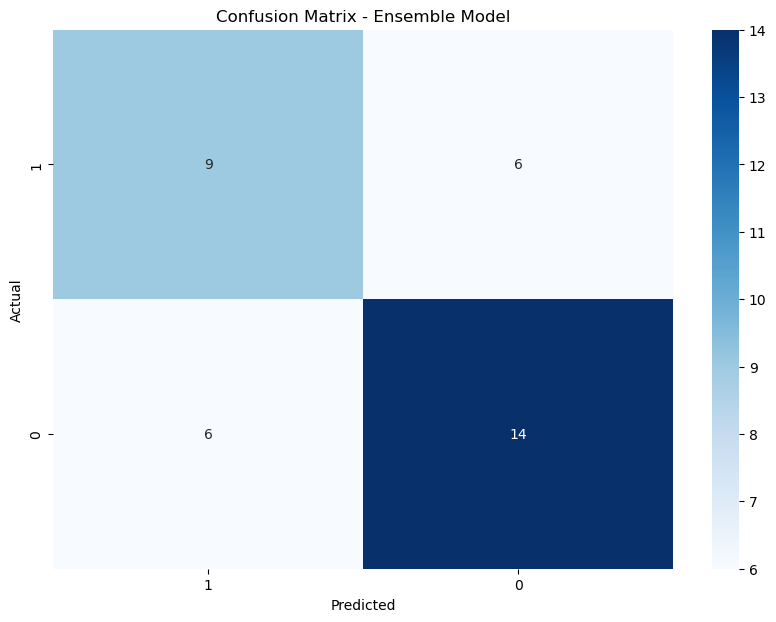

In [23]:
# Generate and plot the confusion matrix

cm = confusion_matrix(y_test, y_pred_meta)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

## Step 4: Evaluation

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


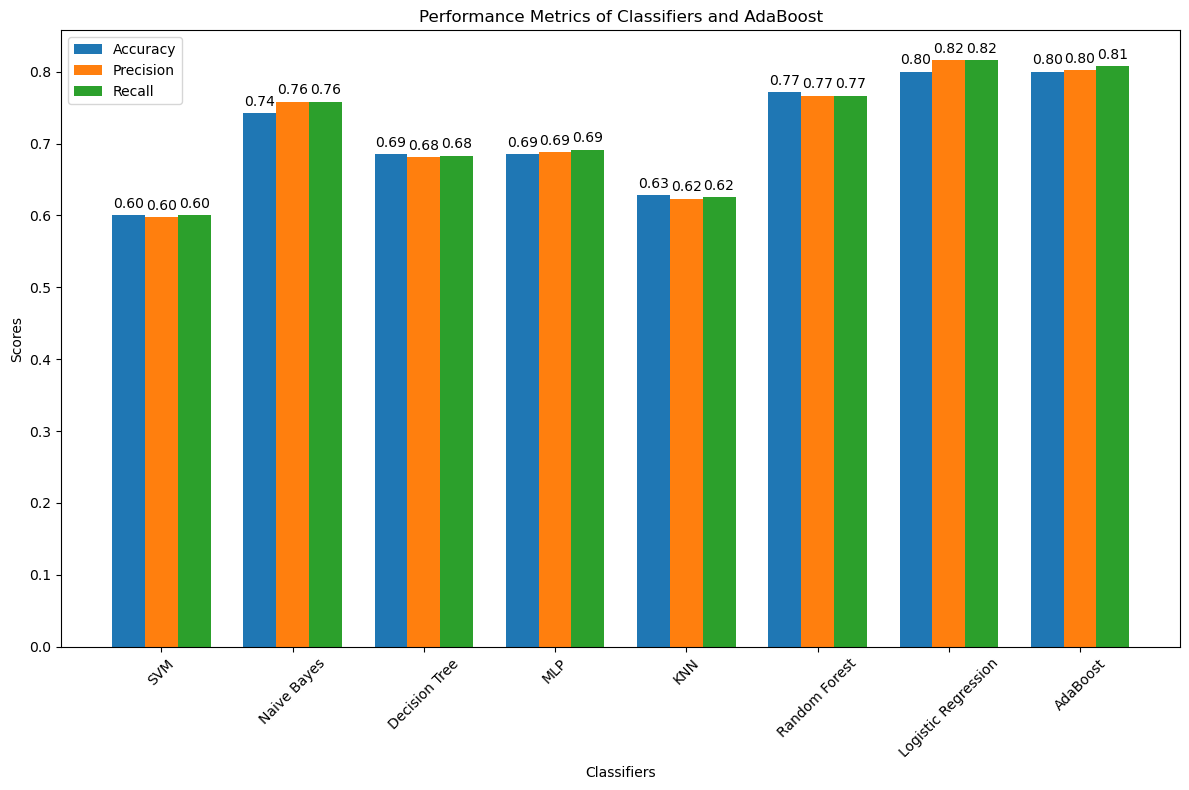

In [24]:
# Train and predict with individual classifiers
svm = SVC(probability=True)
nb = GaussianNB()
dt = DecisionTreeClassifier()
mlp = MLPClassifier(max_iter=1000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression(max_iter=1000)
adaboost = AdaBoostClassifier(n_estimators=50)

classifiers = {
    'SVM': svm,
    'Naive Bayes': nb,
    'Decision Tree': dt,
    'MLP': mlp,
    'KNN': knn,
    'Random Forest': rf,
    'Logistic Regression': lr,
    'AdaBoost': adaboost
}

y_preds = {}
for clf_name, clf in classifiers.items():
    clf.fit(X_train_best, y_train)
    y_preds[clf_name] = clf.predict(X_test_best)

# Calculate accuracy, precision, and recall for each classifier
accuracy_scores = {clf_name: accuracy_score(y_test, y_preds[clf_name]) for clf_name in y_preds}
precision_scores = {clf_name: precision_score(y_test, y_preds[clf_name], average='macro') for clf_name in y_preds}
recall_scores = {clf_name: recall_score(y_test, y_preds[clf_name], average='macro') for clf_name in y_preds}

# Plotting
labels = list(y_preds.keys())
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, [accuracy_scores[clf_name] for clf_name in labels], width, label='Accuracy')
rects2 = ax.bar(x, [precision_scores[clf_name] for clf_name in labels], width, label='Precision')
rects3 = ax.bar(x + width, [recall_scores[clf_name] for clf_name in labels], width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classifiers and AdaBoost')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Function to add labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


### CV for k=2, 5, and 10

In [25]:
# Define k values
k_values = [2, 5, 10]

# Define scoring metrics (accuracy, precision, recall)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0)
}

# Selected feature names
selected_feature_names = ['disp_index1', 'gmrt_on_paper1', 'max_x_extension1', 'mean_acc_in_air1',
                          'mean_acc_on_paper1', 'mean_jerk_on_paper1', 'mean_speed_in_air1', 'num_of_pendown1',
                          'paper_time1', 'air_time2', 'max_y_extension2', 'mean_gmrt2', 'mean_jerk_in_air2',
                          'mean_jerk_on_paper2', 'pressure_mean2', 'total_time2', 'disp_index3', 'max_y_extension3',
                          'mean_jerk_in_air3', 'mean_jerk_on_paper3', 'mean_speed_in_air3', 'num_of_pendown3']

# Extract the best set of features using column names
X_train_best = X_train[selected_feature_names].values
X_test_best = X_test[selected_feature_names].values

# Scale the data
scaler = StandardScaler()
X_train_best = scaler.fit_transform(X_train_best)
X_test_best = scaler.transform(X_test_best)

# Perform cross-validation
results = {}
for clf_name, clf in classifiers.items():
    clf_results = {}
    for k in k_values:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores_accuracy = cross_val_score(clf, X_train_best, y_train, cv=cv, scoring='accuracy')
        scores_precision = cross_val_score(clf, X_train_best, y_train, cv=cv, scoring='precision_weighted')
        scores_recall = cross_val_score(clf, X_train_best, y_train, cv=cv, scoring='recall_weighted')

        clf_results[k] = {
            'accuracy': np.mean(scores_accuracy),
            'precision': np.mean(scores_precision),
            'recall': np.mean(scores_recall)
        }

    results[clf_name] = clf_results

# Print results
for clf_name, clf_result in results.items():
    print(f"{clf_name}:")
    for k, metrics in clf_result.items():
        print(f"  k={k}: Accuracy={metrics['accuracy']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")
    print()

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be remov

SVM:
  k=2: Accuracy=0.590, Precision=0.652, Recall=0.590
  k=5: Accuracy=0.661, Precision=0.685, Recall=0.661
  k=10: Accuracy=0.654, Precision=0.684, Recall=0.654

Naive Bayes:
  k=2: Accuracy=0.640, Precision=0.662, Recall=0.640
  k=5: Accuracy=0.640, Precision=0.670, Recall=0.640
  k=10: Accuracy=0.648, Precision=0.711, Recall=0.648

Decision Tree:
  k=2: Accuracy=0.619, Precision=0.646, Recall=0.662
  k=5: Accuracy=0.662, Precision=0.650, Recall=0.663
  k=10: Accuracy=0.626, Precision=0.653, Recall=0.647

MLP:
  k=2: Accuracy=0.633, Precision=0.645, Recall=0.633
  k=5: Accuracy=0.604, Precision=0.624, Recall=0.604
  k=10: Accuracy=0.596, Precision=0.633, Recall=0.588

KNN:
  k=2: Accuracy=0.597, Precision=0.639, Recall=0.597
  k=5: Accuracy=0.654, Precision=0.668, Recall=0.654
  k=10: Accuracy=0.655, Precision=0.678, Recall=0.655

Random Forest:
  k=2: Accuracy=0.691, Precision=0.714, Recall=0.684
  k=5: Accuracy=0.719, Precision=0.729, Recall=0.719
  k=10: Accuracy=0.648, Precisi

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


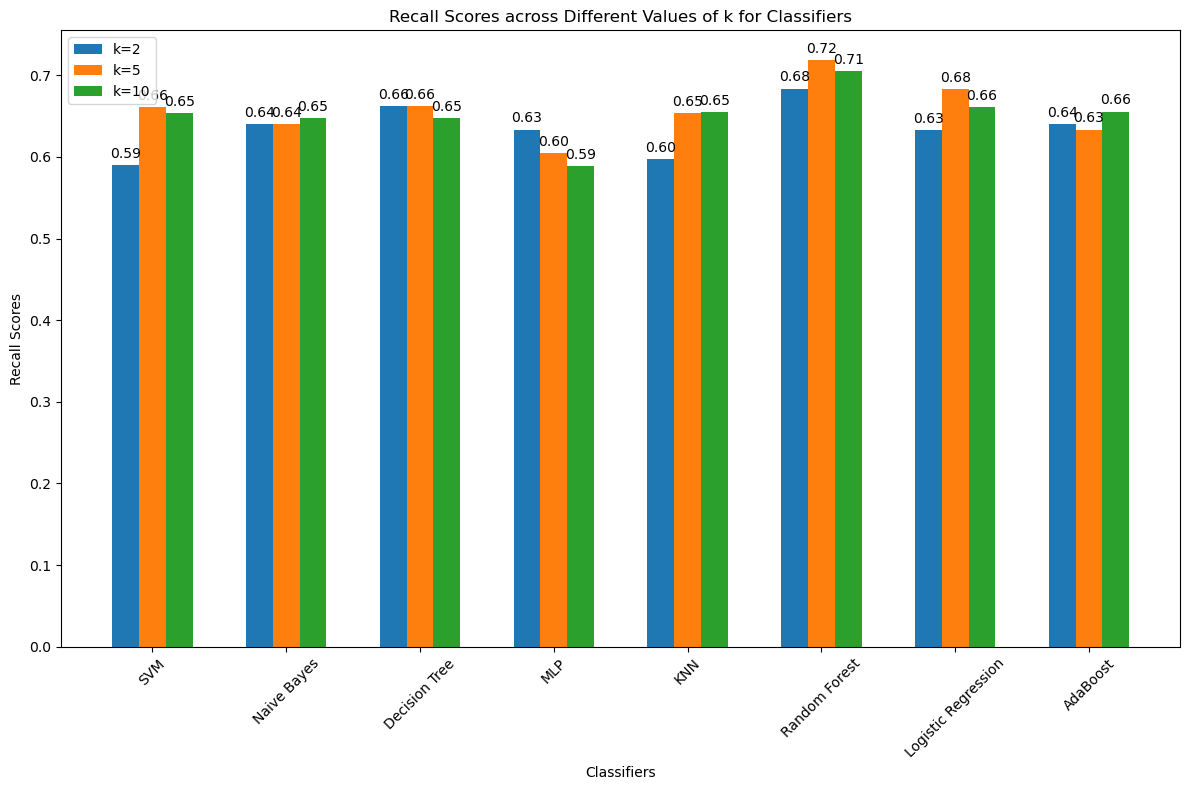

In [26]:
recall_scores = {2: {}, 5: {}, 10: {}}

for clf_name, clf_result in results.items():
    for k, metrics in clf_result.items():
        recall_scores[k][clf_name] = metrics['recall']

classifiers = list(results.keys())
k_values = [2, 5, 10]
recall_data = [[recall_scores[k][clf] for clf in classifiers] for k in k_values]

labels = classifiers
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('default')  # Ensuring white background

rects1 = ax.bar(x - width, recall_data[0], width, label='k=2')
rects2 = ax.bar(x, recall_data[1], width, label='k=5')
rects3 = ax.bar(x + width, recall_data[2], width, label='k=10')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Recall Scores')
ax.set_title('Recall Scores across Different Values of k for Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(loc='upper left')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## Best clasifier: Random Forest

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train_selected, y_train)
    y_pred_rf = clf_rf.predict(X_test_selected)

In [27]:
final_clf_rf = RandomForestClassifier()    
final_clf_rf.fit(X_train_selected, y_train)

RandomForestClassifier()

In [28]:
# Evaluate the final classifier
final_pred = final_clf_rf.predict(X_test_selected)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final model accuracy with top features: {final_accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for more detailed evaluation
class_report = classification_report(y_test, final_pred, target_names=['H', 'P'])
print("Classification Report:")
print(class_report)

Final model accuracy with top features: 0.8285714285714286
Confusion Matrix:
[[14  1]
 [ 5 15]]
Classification Report:
              precision    recall  f1-score   support

           H       0.74      0.93      0.82        15
           P       0.94      0.75      0.83        20

    accuracy                           0.83        35
   macro avg       0.84      0.84      0.83        35
weighted avg       0.85      0.83      0.83        35



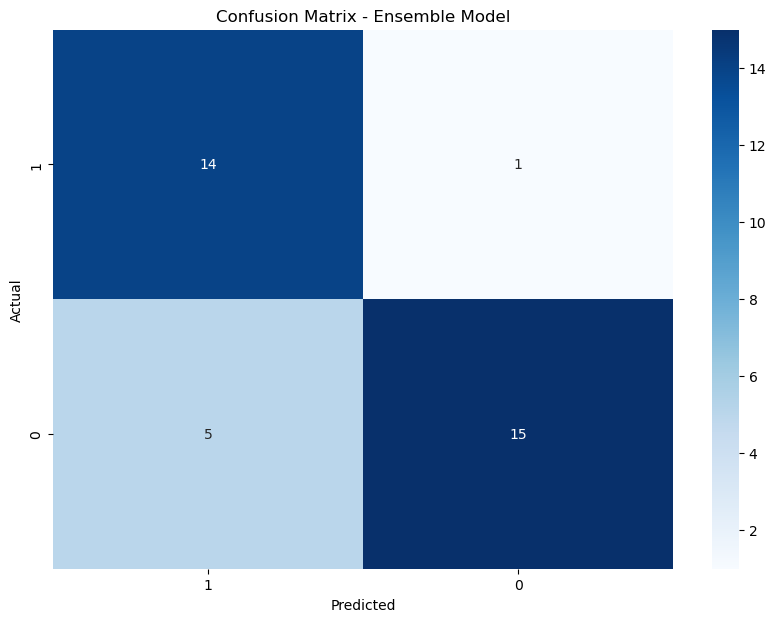

In [29]:
# Generate and plot the confusion matrix

cm = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

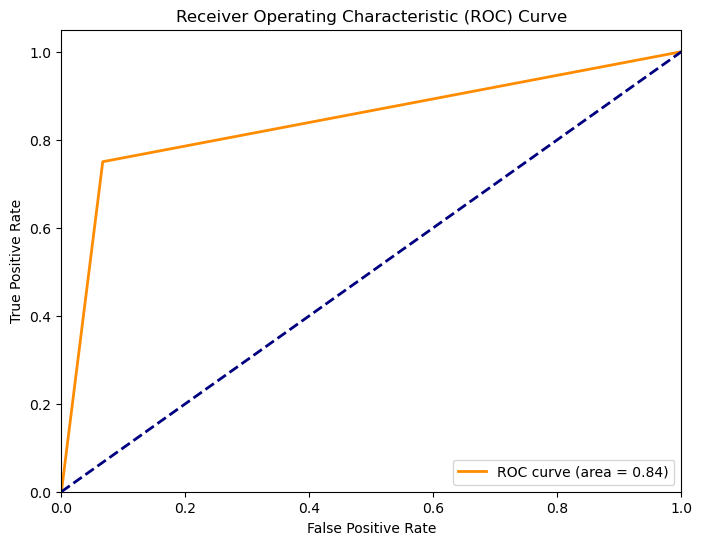

In [30]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, final_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()